In [2]:
# facenet_pytorch_c: avoid confusion with system default facenet_pytorch
#from facenet_pytorch_c import MTCNN

from tqdm import tqdm
import numpy as np
import os

# pytorch
import torch
import torch.optim as optim
from torch import nn

# data handling
from torch.utils.data import DataLoader

# torchvision libs
import torchvision
from torchvision import datasets
from torchvision import transforms
import PIL

import utils_pnet as utils


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: " + str(device))

# training hyperparameters
learning_rate = 1e-2
epochs = 200
decay_step = [100, 150]
decay_rate = 0.1
opt = 'Adam'    # either Adam or SGD
batch_size = 128

# data loading parameters
workers = 4

Available device: cuda:0


 28%|██▊       | 992/3605 [00:22<01:01, 42.41it/s]

### ERROR ###
id: 995
3_3.jpg
o_fb: [ 50  75 320 325]


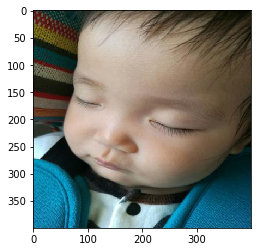

100%|██████████| 3605/3605 [00:59<00:00, 61.04it/s] 

42477
print freq: 326


In [5]:
x_t, b_prob_t, b_box_t, _, _, x_v, b_prob_v, b_box_v, _, _ = utils.get_images(
    '/home/ubuntu/db_proc/db/images',
    '/home/ubuntu/db_proc/db/annotations',
    valid_percent=0.1,
    resize_shape=(48,48)
)

print(len(x_t))
print_freq = int(len(x_t)/batch_size - 5)
print("print freq: {}".format(print_freq))

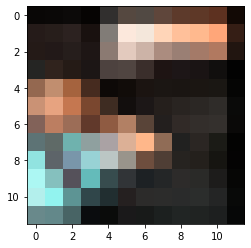

body: [ 0  3  8 12], face: [0 4 3 7]


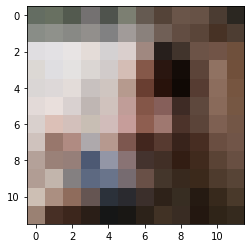

body: [ 4  2  9 11], face: [5 2 7 5]


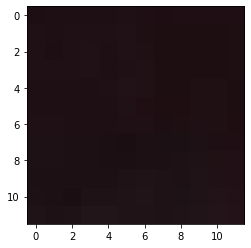

body: [0 0 0 0], face: [0 0 0 0]


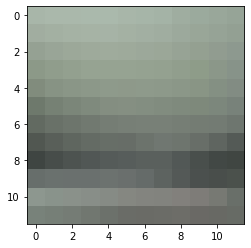

body: [0 0 0 0], face: [0 0 0 0]


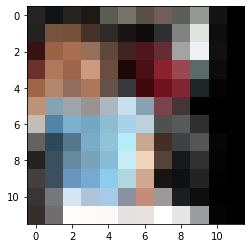

body: [ 0  1  8 11], face: [1 1 4 5]


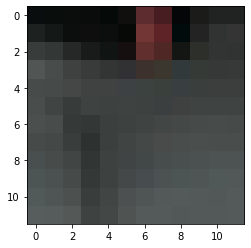

body: [0 0 0 0], face: [0 0 0 0]


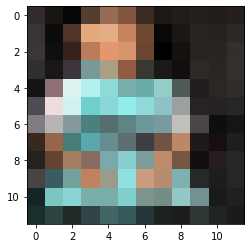

body: [ 0  0  9 11], face: [3 0 7 4]


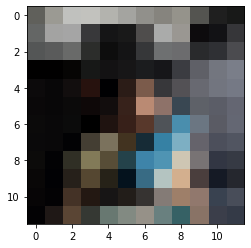

body: [ 3  4 11 12], face: [6 4 8 7]


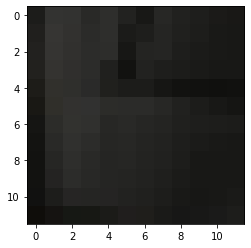

body: [0 0 0 0], face: [0 0 0 0]


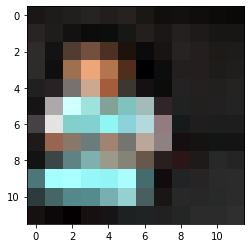

body: [ 0  1  8 11], face: [3 3 5 5]


In [6]:

for i in range(0, 300, 30):
    plt.imshow(x_t[i])
    plt.show()
    print("body: {}, face: {}".format(b_box_t[i], f_box_t[i]))

In [7]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_ds = utils.CIVDS(x_t, b_prob_t, b_box_t, f_prob_t, f_box_t, trsfm=transform_train)

valid_ds = utils.CIVDS(x_v, b_prob_v, b_box_v, f_prob_v, f_box_v, trsfm=transform_valid)

train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    num_workers=workers, shuffle=True
)

valid_loader = DataLoader(
    valid_ds, batch_size=batch_size,
    num_workers=workers, shuffle=False
)

In [8]:
class PNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.prelu1 = nn.PReLU(10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=3)
        self.prelu2 = nn.PReLU(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.prelu3 = nn.PReLU(32)
        
        self.conv4_1 = nn.Conv2d(32, 2, kernel_size=1) # body prob
        self.softmax4_1 = nn.Softmax(dim=1)
        
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1) # body bbox
        
        self.conv4_3 = nn.Conv2d(32, 2, kernel_size=1) # face prob
        self.softmax4_3 = nn.Softmax(dim=1)
        
        self.conv4_4 = nn.Conv2d(32, 4, kernel_size=1) # face bbox
        
        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        
        a = self.conv4_1(x) # body prob
        a = self.softmax4_1(a)
        
        b = self.conv4_2(x) # body bbox
        
        c = self.conv4_3(x) # face prob
        c = self.softmax4_3(c)
        
        d = self.conv4_4(x) # face bbox
        
        return a, b, c, d


In [9]:
pnet = PNet()
pnet.train()
pnet.to(device)

PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (prelu1): PReLU(num_parameters=10)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (prelu2): PReLU(num_parameters=16)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (prelu3): PReLU(num_parameters=32)
  (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (softmax4_1): Softmax(dim=1)
  (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (conv4_3): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (softmax4_3): Softmax(dim=1)
  (conv4_4): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
)

In [10]:

from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir="/home/ubuntu/tensorLog") # tensorboard writer

prob_lossfn = nn.BCELoss().to(device)
bbox_lossfn = nn.MSELoss().to(device)

optimizer = None

if opt == "Adam":
    print("Optimizer: Adam")
    optimizer = torch.optim.Adam(pnet.parameters(), lr=learning_rate, amsgrad=True)
elif opt == "SGD":
    print("Optimizer: SGD")
    optimizer = torch.optim.SGD(pnet.parameters(), lr=learning_rate, momentum=0.9)
else:
    print("Error")

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_step, gamma=decay_rate)

rl1, rl2, rl3, rl4 = 0, 0, 0, 0

for epoch in range(1, epochs+1):
    
    for batch_idx, data in enumerate(train_loader):
        
        im, b_prob, b_box, f_prob, f_box = data
        
        im = im.to(device)
        b_prob = b_prob.float().to(device)
        b_box = b_box.float().to(device)
        f_prob = f_prob.float().to(device)
        f_box = f_box.float().to(device)
        
        o_b_prob, o_b_box, o_f_prob, o_f_box = pnet(im)
        
        o_b_prob = o_b_prob.float().squeeze()
        o_b_box = o_b_box.float().squeeze()
        o_f_prob = o_f_prob.float().squeeze()
        o_f_box = o_f_box.float().squeeze()
        
        b_prob_l = prob_lossfn(o_b_prob, b_prob)
        b_box_l = bbox_lossfn(o_b_box, b_box)
        f_prob_l = prob_lossfn(o_f_prob, f_prob)
        f_box_l = bbox_lossfn(o_f_box, f_box)
        
        rl1 += b_prob_l.item()
        rl2 += b_box_l.item()
        rl3 += f_prob_l.item()
        rl4 += f_box_l.item()
        
        all_loss = b_prob_l*0.9 + b_box_l + f_prob_l*0.9 + f_box_l
        
        if batch_idx % print_freq == print_freq-1:
            
            print(
                "ep: {}; bpl: {:.2f}; bbl: {:.2f}; fpl: {:.2f}; fbl: {:.2f};".format(
                    epoch, rl1/print_freq, rl2/print_freq, rl4/print_freq, rl4/print_freq,
                )
            )
            writer.add_scalar('bpl', rl1/print_freq, epoch)
            writer.add_scalar('bbl', rl2/print_freq, epoch)
            writer.add_scalar('fpl', rl3/print_freq, epoch)
            writer.add_scalar('fbl', rl4/print_freq, epoch)
            
            rl1, rl2, rl3, rl4 = 0, 0, 0, 0

        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
    
    scheduler.step()

print("finished training")

save_name = 'cd_pnet_xtradata.pt'
torch.save(pnet.state_dict(), save_name)
print('Saved model at {}'.format(save_name))

Optimizer: Adam
ep: 1; bpl: 0.31; bbl: 5.58; fpl: 4.48; fbl: 4.48;
ep: 2; bpl: 0.23; bbl: 3.60; fpl: 3.18; fbl: 3.18;
ep: 3; bpl: 0.20; bbl: 2.93; fpl: 2.73; fbl: 2.73;
ep: 4; bpl: 0.19; bbl: 2.60; fpl: 2.48; fbl: 2.48;
ep: 5; bpl: 0.18; bbl: 2.39; fpl: 2.34; fbl: 2.34;
ep: 6; bpl: 0.18; bbl: 2.28; fpl: 2.27; fbl: 2.27;
ep: 7; bpl: 0.17; bbl: 2.10; fpl: 2.17; fbl: 2.17;
ep: 8; bpl: 0.17; bbl: 2.02; fpl: 2.06; fbl: 2.06;
ep: 9; bpl: 0.17; bbl: 1.94; fpl: 2.03; fbl: 2.03;
ep: 10; bpl: 0.16; bbl: 1.84; fpl: 1.94; fbl: 1.94;
ep: 11; bpl: 0.16; bbl: 1.75; fpl: 1.88; fbl: 1.88;
ep: 12; bpl: 0.15; bbl: 1.67; fpl: 1.84; fbl: 1.84;
ep: 13; bpl: 0.16; bbl: 1.71; fpl: 1.82; fbl: 1.82;
ep: 14; bpl: 0.15; bbl: 1.60; fpl: 1.76; fbl: 1.76;
ep: 15; bpl: 0.15; bbl: 1.54; fpl: 1.71; fbl: 1.71;
ep: 16; bpl: 0.15; bbl: 1.53; fpl: 1.71; fbl: 1.71;
ep: 17; bpl: 0.15; bbl: 1.47; fpl: 1.67; fbl: 1.67;
ep: 18; bpl: 0.15; bbl: 1.51; fpl: 1.69; fbl: 1.69;
ep: 19; bpl: 0.14; bbl: 1.37; fpl: 1.61; fbl: 1.61;
ep: 2

KeyboardInterrupt: 

In [ ]:
total = len(valid_ds)
b_err, f_err = 0, 0
bt, bp, ft, fp = [], [], [], []

hasFace = 0

for idx in range(0, total):
    
    obp, obb, ofp, ofb  = pnet(valid_ds[idx][0].unsqueeze(0).to(device))
    obp, ofp = obp.squeeze(), ofp.squeeze()
    
    obp = int(obp[0] > obp[1])
    ofp = int(ofp[0] > ofp[1])

    tbp = int(b_prob_v[idx][0] > b_prob_v[idx][1])
    tfp = int(f_prob_v[idx][0] > f_prob_v[idx][1])
    
    hasFace += tfp

    b_err += (obp != tbp)
    f_err += (ofp != tfp)
        
    if idx % 20 == 0:
        plt.imshow(transforms.ToPILImage()(valid_ds[idx][0]))
        plt.show()
        print("tb: {}; pb: {}\ntf: {}; pf: {}".format(int(tbp), int(obp), int(tfp), int(ofp)))
        print("body: " + str(np.rint(obb.cpu().detach().squeeze().numpy())))
        print("face: " + str(np.rint(ofb.cpu().detach().squeeze().numpy())))

print("total: {}".format(total))
print("body accuracy: {:.1f}%".format(100*(total-b_err)/total))
print("face accuracy: {:.1f}%".format(100*(total-f_err)/total))
print("true face count: {}".format(hasFace))
"""
p, r, f1 = utils.f1_score(truth, pred, 0)
print("precision: {:.2f}, recall: {:.2f}, f1: {:.2f}".format(p, r, f1))
print("valid_ds length: {}".format(len(valid_ds)))
print("age dist: ", end='')
""";

In [ ]:
save_name = 'cd_pnet_xtradata.pt'
torch.save(pnet.state_dict(), save_name)
print('Saved model at {}'.format(save_name))